In [1]:
from __future__ import division
from torchvision import models
from torchvision import transforms, datasets
from PIL import Image
import argparse
import torch
import torchvision
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [3]:
# toy example of GAN using MNIST

batch_size=32
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                        std=(0.5, 0.5, 0.5))
])

mnist_data = torchvision.datasets.MNIST("./mnist_data", train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset=mnist_data,
                                         batch_size=batch_size,
                                         shuffle=True)

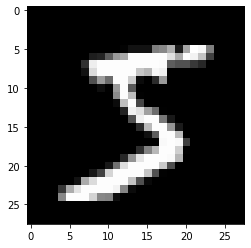

In [4]:
plt.imshow(mnist_data[0][0][0], cmap = plt.cm.gray)

In [5]:
image_size = 28 * 28
hidden_size = 256

# given a image, output a probability which indicates the probability of real image
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(image_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.main(x)

D = Discriminator()

latent_size = 64

# given latent space, generate image
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, image_size),
            nn.Tanh() # every element in the image is in the range of [-1, 1]
        )
    def forward(self, x):
        return self.main(x)

G = Generator()

D = D.to(device)
G = G.to(device)

In [6]:
loss_fn = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr = 0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr = 0.0002)

In [7]:
total_steps = len(dataloader)
epochs = 30

for epoch in range(epochs):
    # optimize discriminator first and then generator
    # there are real and fake images to discriminator
    for i, (images, _) in enumerate(dataloader):
        # images: (batch_size, 1, 28, 28)
        batch_size = images.shape[0]
        images = images.reshape(batch_size, image_size).to(device) # (batch_size, 28*28)
        
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        outputs = D(images) # real images
        d_loss_real = loss_fn(outputs, real_labels)
        real_score = outputs # D wants to maximize this score
        
        # generate fake images
        z = torch.randn(batch_size, latent_size).to(device) # latent variable
        fake_images = G(z)
        outputs = D(fake_images.detach()) # does not need the gradient of generator since this is to train discriminator. So add detach
        d_loss_fake = loss_fn(outputs, fake_labels)
        fake_score = outputs # D wants to minimize this score
        
        # optimzie discriminator
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # optimize generator
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = loss_fn(outputs, real_labels) # use real_labels because generator wants to fool discriminator
        
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if i % 200 == 0:
            print("Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}"
                 .format(epoch, epochs, i, total_steps, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))
        

Epoch [0/30], Step [0/1875], d_loss: 1.3464, g_loss: 0.6809, D(x): 0.53, D(G(z)): 0.51
Epoch [0/30], Step [200/1875], d_loss: 0.0418, g_loss: 4.0355, D(x): 1.00, D(G(z)): 0.04
Epoch [0/30], Step [400/1875], d_loss: 0.0507, g_loss: 5.7532, D(x): 0.99, D(G(z)): 0.04
Epoch [0/30], Step [600/1875], d_loss: 0.0700, g_loss: 5.0512, D(x): 0.97, D(G(z)): 0.04
Epoch [0/30], Step [800/1875], d_loss: 0.0747, g_loss: 6.1633, D(x): 1.00, D(G(z)): 0.07
Epoch [0/30], Step [1000/1875], d_loss: 0.1179, g_loss: 4.5407, D(x): 0.95, D(G(z)): 0.06
Epoch [0/30], Step [1200/1875], d_loss: 0.2809, g_loss: 4.8701, D(x): 0.91, D(G(z)): 0.04
Epoch [0/30], Step [1400/1875], d_loss: 0.1103, g_loss: 3.9326, D(x): 0.94, D(G(z)): 0.04
Epoch [0/30], Step [1600/1875], d_loss: 0.5007, g_loss: 3.5484, D(x): 0.88, D(G(z)): 0.27
Epoch [0/30], Step [1800/1875], d_loss: 0.2700, g_loss: 3.0324, D(x): 0.93, D(G(z)): 0.14
Epoch [1/30], Step [0/1875], d_loss: 0.6824, g_loss: 2.0928, D(x): 0.96, D(G(z)): 0.43
Epoch [1/30], Step [

Epoch [9/30], Step [400/1875], d_loss: 0.7743, g_loss: 4.4634, D(x): 0.94, D(G(z)): 0.40
Epoch [9/30], Step [600/1875], d_loss: 0.3590, g_loss: 3.5591, D(x): 0.89, D(G(z)): 0.05
Epoch [9/30], Step [800/1875], d_loss: 0.7146, g_loss: 2.7717, D(x): 0.92, D(G(z)): 0.32
Epoch [9/30], Step [1000/1875], d_loss: 0.3854, g_loss: 2.6429, D(x): 0.82, D(G(z)): 0.08
Epoch [9/30], Step [1200/1875], d_loss: 0.7539, g_loss: 4.2981, D(x): 0.72, D(G(z)): 0.02
Epoch [9/30], Step [1400/1875], d_loss: 0.5845, g_loss: 2.3297, D(x): 0.90, D(G(z)): 0.23
Epoch [9/30], Step [1600/1875], d_loss: 1.0950, g_loss: 2.4060, D(x): 0.85, D(G(z)): 0.36
Epoch [9/30], Step [1800/1875], d_loss: 0.3076, g_loss: 3.0248, D(x): 0.94, D(G(z)): 0.17
Epoch [10/30], Step [0/1875], d_loss: 0.3872, g_loss: 2.7393, D(x): 0.94, D(G(z)): 0.17
Epoch [10/30], Step [200/1875], d_loss: 0.4453, g_loss: 3.4492, D(x): 0.87, D(G(z)): 0.10
Epoch [10/30], Step [400/1875], d_loss: 0.3316, g_loss: 2.6739, D(x): 0.96, D(G(z)): 0.21
Epoch [10/30], 

Epoch [18/30], Step [600/1875], d_loss: 1.0726, g_loss: 1.7334, D(x): 0.59, D(G(z)): 0.22
Epoch [18/30], Step [800/1875], d_loss: 0.6918, g_loss: 1.0946, D(x): 0.86, D(G(z)): 0.30
Epoch [18/30], Step [1000/1875], d_loss: 0.5243, g_loss: 1.8494, D(x): 0.88, D(G(z)): 0.28
Epoch [18/30], Step [1200/1875], d_loss: 0.7618, g_loss: 2.9875, D(x): 0.67, D(G(z)): 0.13
Epoch [18/30], Step [1400/1875], d_loss: 0.8270, g_loss: 2.1622, D(x): 0.73, D(G(z)): 0.24
Epoch [18/30], Step [1600/1875], d_loss: 0.9975, g_loss: 1.4338, D(x): 0.89, D(G(z)): 0.44
Epoch [18/30], Step [1800/1875], d_loss: 0.6088, g_loss: 2.5122, D(x): 0.77, D(G(z)): 0.18
Epoch [19/30], Step [0/1875], d_loss: 0.6135, g_loss: 2.9584, D(x): 0.77, D(G(z)): 0.14
Epoch [19/30], Step [200/1875], d_loss: 0.6047, g_loss: 2.1007, D(x): 0.76, D(G(z)): 0.16
Epoch [19/30], Step [400/1875], d_loss: 1.1089, g_loss: 2.2448, D(x): 0.69, D(G(z)): 0.27
Epoch [19/30], Step [600/1875], d_loss: 0.7301, g_loss: 1.8749, D(x): 0.84, D(G(z)): 0.32
Epoch [

Epoch [27/30], Step [800/1875], d_loss: 1.4308, g_loss: 1.4803, D(x): 0.51, D(G(z)): 0.22
Epoch [27/30], Step [1000/1875], d_loss: 0.9128, g_loss: 2.6455, D(x): 0.69, D(G(z)): 0.26
Epoch [27/30], Step [1200/1875], d_loss: 1.1819, g_loss: 1.5435, D(x): 0.75, D(G(z)): 0.48
Epoch [27/30], Step [1400/1875], d_loss: 0.6685, g_loss: 2.5688, D(x): 0.72, D(G(z)): 0.19
Epoch [27/30], Step [1600/1875], d_loss: 0.9055, g_loss: 2.2445, D(x): 0.74, D(G(z)): 0.31
Epoch [27/30], Step [1800/1875], d_loss: 0.9014, g_loss: 1.6287, D(x): 0.68, D(G(z)): 0.26
Epoch [28/30], Step [0/1875], d_loss: 0.6928, g_loss: 1.2423, D(x): 0.86, D(G(z)): 0.35
Epoch [28/30], Step [200/1875], d_loss: 0.5862, g_loss: 1.8185, D(x): 0.78, D(G(z)): 0.22
Epoch [28/30], Step [400/1875], d_loss: 0.7186, g_loss: 2.0818, D(x): 0.71, D(G(z)): 0.18
Epoch [28/30], Step [600/1875], d_loss: 0.7124, g_loss: 1.9964, D(x): 0.79, D(G(z)): 0.27
Epoch [28/30], Step [800/1875], d_loss: 0.8022, g_loss: 1.5956, D(x): 0.71, D(G(z)): 0.23
Epoch [

In [8]:
# test to generate fake images
z = torch.randn(batch_size, latent_size).to(device)
fake_images = G(z)

In [9]:
fake_images.shape

torch.Size([32, 784])

In [10]:
fake_images = fake_images.view(batch_size, 28, 28).data.cpu().numpy()

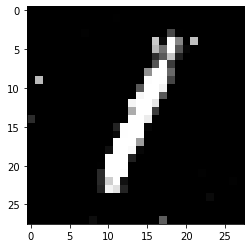

In [12]:
plt.imshow(fake_images[1], cmap=plt.cm.gray)

In [ ]:
# implementation of DCGAN (https://arxiv.org/pdf/1511.06434.pdf)
# it uses deconv layer (https://arxiv.org/pdf/1603.07285.pdf), in pytorch it is ConvTranspose

In [2]:
import torchvision.utils as vutils

In [3]:
image_size=64
batch_size=128
num_workers = 2
dataroot="./images"
dataset = torchvision.datasets.ImageFolder(root=dataroot, transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

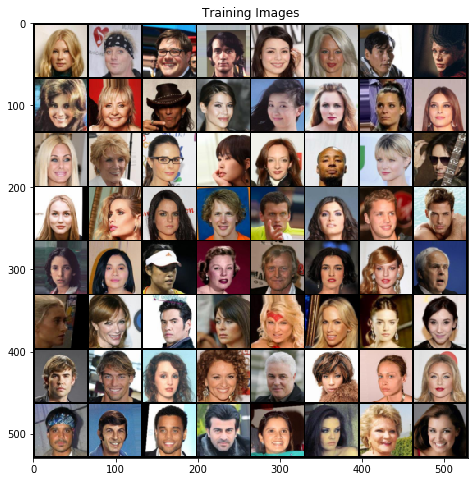

In [4]:
real_batch=next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis=("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1,2,0)))

In [5]:
# weight initialization from https://arxiv.org/pdf/1511.06434.pdf
def weight_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
latent_size = 100
num_generated_features = 64
num_channel = 3

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_size, num_generated_features*8, 4, 1, 0),
            nn.BatchNorm2d(num_generated_features*8),
            nn.ReLU(True),
            # state size (batch_size, num_generated_features*8, 4, 4) -> since ConvTranspose2d is the inverse of conv2d. The other way to think is if we pass (batch_size, num_generated_features*8, 4, 4) to a conv2d, we will get (batch_size, latent_size, 1, 1)
            nn.ConvTranspose2d(num_generated_features*8, num_generated_features*4, 4, 2, 1),
            nn.BatchNorm2d(num_generated_features*4),
            nn.ReLU(True),
            # state size (batch_size, num_generated_features*4, 8, 8)
            nn.ConvTranspose2d(num_generated_features*4, num_generated_features*2, 4, 2, 1),
            nn.BatchNorm2d(num_generated_features*2),
            nn.ReLU(True),
            # state size (batch_size, num_generated_features*2, 16, 16)
            nn.ConvTranspose2d(num_generated_features*2, num_generated_features, 4, 2, 1),
            nn.BatchNorm2d(num_generated_features),
            nn.ReLU(True),
            # state size (batch_size, num_generated_features, 32, 32)
            nn.ConvTranspose2d(num_generated_features, num_channel, 4, 2, 1),
            nn.Tanh() # make sure every pixel is in the range of [-1, 1]
            # state size (batch_size, num_channel, 64, 64)
        )
        
    def forward(self, x):
        return self.main(x)

In [7]:
G = Generator().to(device)
G.apply(weight_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input: (batch_size, num_channel, 64, 64)
            nn.Conv2d(num_channel, num_generated_features, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (batch_size, num_generated_features, 32, 32)
            nn.Conv2d(num_generated_features, num_generated_features * 2, 4, 2, 1),
            nn.BatchNorm2d(num_generated_features * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (batch_size, num_generated_features*2, 16, 16)
            nn.Conv2d(num_generated_features * 2, num_generated_features * 4, 4, 2, 1),
            nn.BatchNorm2d(num_generated_features * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (batch_size, num_generated_features*4, 8, 8)
            nn.Conv2d(num_generated_features * 4, num_generated_features * 8, 4, 2, 1),
            nn.BatchNorm2d(num_generated_features * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (batch_size, num_generated_features*8, 4, 4)
            nn.Conv2d(num_generated_features * 8, 1, 4, 1, 0), # (batch_size, 1, 1, 1)
            nn.Sigmoid() # (batch_size, 1, 1, 1)
        )
    
    def forward(self, x):
        return self.main(x)

In [9]:
D = Discriminator().to(device)
D.apply(weight_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)

In [10]:
lr = 0.0002
beta1 = 0.5

loss_fn = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

In [11]:
for i, j in enumerate(dataloader):
    print(j[0].shape)
    break

torch.Size([128, 3, 64, 64])


In [12]:
total_steps = len(dataloader)
epochs = 5

for epoch in range(epochs):
    # optimize discriminator first and then generator
    # there are real and fake images to discriminator
    for i, (images, _) in enumerate(dataloader):
        
        batch_size = images.shape[0]
        images = images.to(device) # images: (batch_size, 3, 64, 64)
        
        real_labels = torch.ones(batch_size).to(device)
        fake_labels = torch.zeros(batch_size).to(device)
        
        outputs = D(images).squeeze() # real images
        d_loss_real = loss_fn(outputs, real_labels)
        real_score = outputs # D wants to maximize this score
        
        # generate fake images
        z = torch.randn(batch_size, latent_size, 1, 1).to(device) # latent variable
        fake_images = G(z)
        outputs = D(fake_images.detach()).squeeze() # does not need the gradient of generator since this is to train discriminator. So add detach
        d_loss_fake = loss_fn(outputs, fake_labels)
        fake_score = outputs # D wants to minimize this score
        
        # optimzie discriminator
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # optimize generator
        z = torch.randn(batch_size, latent_size,1, 1).to(device)
        fake_images = G(z)
        outputs = D(fake_images).squeeze()
        g_loss = loss_fn(outputs, real_labels) # use real_labels because generator wants to fool discriminator
        
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if i % 200 == 0:
            print("Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}"
                 .format(epoch, epochs, i, total_steps, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))
        

Epoch [0/5], Step [0/1583], d_loss: 1.8269, g_loss: 8.1727, D(x): 0.76, D(G(z)): 0.72
Epoch [0/5], Step [200/1583], d_loss: 1.0117, g_loss: 5.4679, D(x): 0.75, D(G(z)): 0.39
Epoch [0/5], Step [400/1583], d_loss: 0.6560, g_loss: 4.9088, D(x): 0.80, D(G(z)): 0.25
Epoch [0/5], Step [600/1583], d_loss: 0.5675, g_loss: 4.3326, D(x): 0.83, D(G(z)): 0.26
Epoch [0/5], Step [800/1583], d_loss: 1.0868, g_loss: 4.9256, D(x): 0.92, D(G(z)): 0.56
Epoch [0/5], Step [1000/1583], d_loss: 1.1418, g_loss: 7.0621, D(x): 0.93, D(G(z)): 0.60
Epoch [0/5], Step [1200/1583], d_loss: 1.0854, g_loss: 1.9803, D(x): 0.55, D(G(z)): 0.22
Epoch [0/5], Step [1400/1583], d_loss: 0.4389, g_loss: 2.8972, D(x): 0.83, D(G(z)): 0.18
Epoch [1/5], Step [0/1583], d_loss: 0.8069, g_loss: 2.0116, D(x): 0.53, D(G(z)): 0.05
Epoch [1/5], Step [200/1583], d_loss: 0.4964, g_loss: 2.5517, D(x): 0.75, D(G(z)): 0.14
Epoch [1/5], Step [400/1583], d_loss: 0.6524, g_loss: 2.1486, D(x): 0.64, D(G(z)): 0.10
Epoch [1/5], Step [600/1583], d_l

In [13]:
fixed_noise = torch.randn(64, latent_size, 1, 1, device=device)
with torch.no_grad():
    fake = G(fixed_noise).detach().cpu()

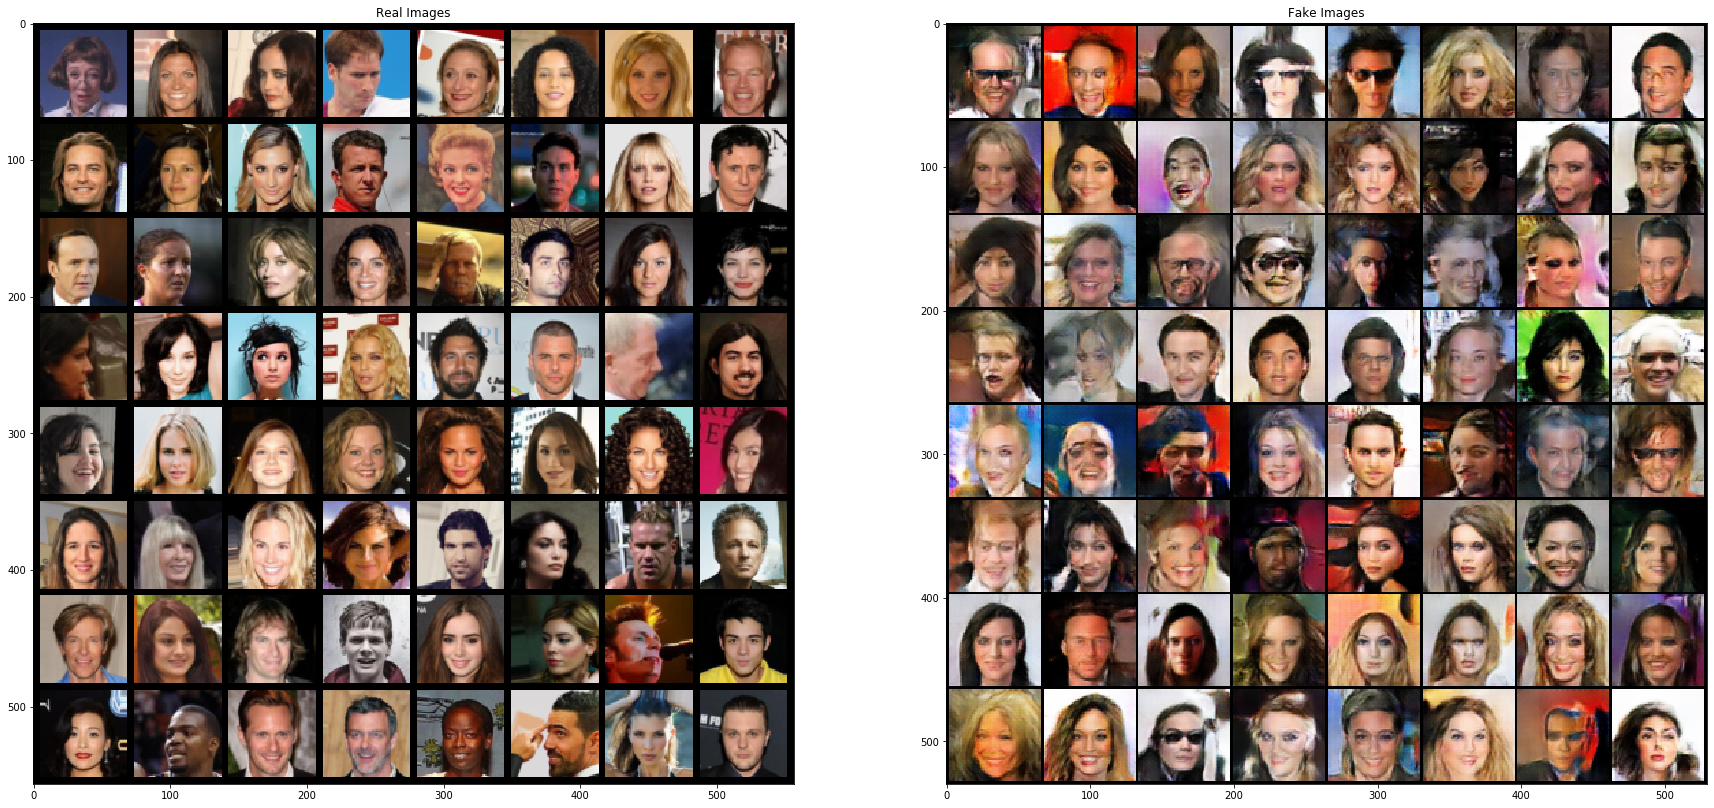

In [14]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(30,30))
plt.subplot(1,2,1)
plt.axis=("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis=("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1,2,0)))
plt.show()